# 2 - Feature Engineering<p>
Import libraries and first dataset.

In [99]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [100]:
dc_hour = pd.read_csv('../dc-data/hour.csv')
dc_day = pd.read_csv('../dc-data/day.csv')

## -> DC Dataset

Fill in the missing hour values

In [101]:
from feat_eng_functions import fill_hours_dc
dc_filled = fill_hours_dc(dc_hour)

Filling values that are identical within each day:<br>
(Trying to do this in a function resulted in unexpected NaNs, so I am doing it like this.)


In [102]:
dc_filled.loc[:,'season'] = dc_filled.groupby('dteday')['season'].transform(lambda x: x.fillna(x.mean().astype(int)))
dc_filled.loc[:, 'yr'] = dc_filled.groupby('dteday')['yr'].transform(lambda x: x.fillna(x.mean().astype(int)))
dc_filled.loc[:, 'mnth'] = dc_filled.groupby('dteday')['mnth'].transform(lambda x: x.fillna(x.mean().astype(int)))
dc_filled.loc[:, 'holiday'] = dc_filled.groupby('dteday')['holiday'].transform(lambda x: x.fillna(x.mean().astype(int)))
dc_filled.loc[:, 'weekday'] = dc_filled.groupby('dteday')['weekday'].transform(lambda x: x.fillna(x.mean().astype(int)))
dc_filled.loc[:, 'workingday'] = dc_filled.groupby('dteday')['workingday'].transform(lambda x: x.fillna(x.mean().astype(int)))

Using interpolate to fill values that move throughout a day:

In [103]:
dc_filled.loc[:,'temp'] = dc_filled['temp'].interpolate(method='linear', limit_direction='both').round(2)
dc_filled.loc[:,'atemp'] = dc_filled['atemp'].interpolate(method='linear', limit_direction='both').round(4)
dc_filled.loc[:,'hum'] = dc_filled['hum'].interpolate(method='linear', limit_direction='both').round(2)
dc_filled.loc[:,'windspeed'] = dc_filled['windspeed'].interpolate(method='linear', limit_direction='both').round(4)

Using the `dc_day` table's `weathersit` column as an 'overall' weather value for that day to fill missing weather values. 

In [104]:
dc_day['dteday'] = pd.to_datetime(dc_day['dteday'])
dc_filled = dc_filled.merge(dc_day[['dteday','weathersit']],on='dteday',how='left')
dc_filled['weathersit_x'] = dc_filled['weathersit_x'].fillna(dc_filled['weathersit_y'])

Making a categorical `precip` colunmn for whether or not there was precipitation, based on documentation's description of `weathersit` values;<p>
**0 (no precipitation):**<ul>
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy<br>
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist</ul>

**1 (precipitation):**<ul>
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds<br>
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog


In [105]:
precip_map = {1:0,2:0,3:1,4:1}
dc_filled['precip'] = dc_filled['weathersit_x'].map(precip_map)

Make a column for the numerical day of the month from the `dteday` column, since I have been advised I don't have a long enough interval to do a proper timeseries analysis, and I have the other elements of the date in their own columns anyways.

In [106]:
from feat_eng_functions import get_day
dc_filled['day'] = dc_filled['dteday'].apply(lambda x: get_day(x))

Clean up table; turn floats back to int, rename columns, drop extra `weathersit` column. Also drop `casual` and `registered`, as they are redundant to `cnt` and not needed.<br>
_(Doing this via column select so I can reorder the columns to my liking.)_

In [107]:
dc_data = dc_filled[['dteday','season','yr','mnth','day','hr','weekday',
    'holiday','workingday','weathersit_x','precip','temp','atemp','hum','windspeed','cnt']]

In [108]:
dc_data[['season','yr','mnth','holiday','weekday','workingday','weathersit_x','cnt']] = dc_data[['season','yr','mnth','holiday','weekday','workingday','weathersit_x','cnt']].astype(int)

In [109]:
dc_data = dc_data.rename(columns={'dteday':'date','yr':'year','mnth':'month','hr':'hour',
'weathersit_x':'weather','hum':'humidity','cnt':'count'})

## -> London Dataset<p>
Import second dataset.

In [110]:
london = pd.read_csv('../london-data/london_merged.csv')

Match `season` column to DC dataset:<ul>
0 -> 1 (spring)<br>
1 -> 2 (summer)<br>
2 -> 3 (fall)<br>
3 -> 4 (winter)

In [111]:
seas_map = {0:1,1:2,2:3,3:4}
london['season'] = london['season'].map(seas_map)

Match `weather_code` to DC dataset:<p>

**1: Clear, Few clouds, Partly cloudy, Partly cloudy**<br>
Mapping in:<ul>
1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity<br>
2 = scattered clouds / few clouds </ul>

**2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist**<br>
Mapping in:<ul>
3 = Broken clouds<br>
4 = Cloudy</ul>

**3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds**<br>
Mapping in:<ul>
7 = Rain/ light Rain shower/ Light rain</ul>

**4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog**<br>
Mapping in:<ul>
10 = rain with thunderstorm<br>
26 = snowfall<br>
94 = Freezing Fog

In [112]:
weather_map = {1:1,2:1,3:2,4:2,7:3,10:4,26:4,94:4}
london['weather_code'] = london['weather_code'].map(weather_map)

Create `workingday` column using `is_holiday` and `is_weekend` columns; any day that has a **1** in either column is not a working day and gets a 0 in the new column.

In [113]:
# create new column with default value 1
london['workingday'] = 1

# assign 0 in appropriate rows
london.loc[((london[(london['is_holiday']==1.0)| # is a holiday OR
                    (london['is_weekend']==1.0)  # is a weekend 
                    ].index).tolist()), 'workingday'] = 0 

Get `hours` column out of `timestamp`, and then check for missing hour rows. (The prior function was specific to the column names of the DC dataset, so another one is necessary.)

In [114]:
from feat_eng_functions import get_hour

london['timestamp'] = pd.to_datetime(london['timestamp'])

london['hour'] = london['timestamp'].apply(lambda x: get_hour(x))

In [115]:
from feat_eng_functions import fill_hours_london
london_filled = fill_hours_london(london)

Get the rest of the time-related values out of the `timestamp` column; `year`, `month`, `day` and `weekday`.

In [116]:
from feat_eng_functions import get_year, get_month, get_weekday

In [117]:
london_filled['year'] = london_filled['timestamp'].apply(lambda x: get_year(x))
london_filled['month'] = london_filled['timestamp'].apply(lambda x: get_month(x))
london_filled['day'] = london_filled['timestamp'].apply(lambda x: get_day(x))
london_filled['weekday'] = london_filled['timestamp'].apply(lambda x: get_weekday(x))

Fill values that are uniform for each day using `groupby` and `mean`, same as the DC dataset.

In [118]:
london_filled.loc[:, 'season'] = london_filled.groupby(['year','month','day'])['season'].transform(lambda x: x.fillna(x.mean()))
london_filled.loc[:, 'workingday'] = london_filled.groupby(['year','month','day'])['workingday'].transform(lambda x: x.fillna(x.mean()))
london_filled.loc[:, 'is_holiday'] = london_filled.groupby(['year','month','day'])['is_holiday'].transform(lambda x: x.fillna(x.mean()))

Any rows that still have NaNs after this step are missing all of their data, and need to be dropped. 

In [119]:
london_filled = london_filled.dropna(subset=['season','workingday','is_holiday'])

In [120]:
london_filled[['season','workingday','is_holiday']].isna().value_counts()

season  workingday  is_holiday
False   False       False         17520
Name: count, dtype: int64

Fill NaNs using interpolate for values that move throughout the day, same as the DC dataset:

In [121]:
london_filled.loc[:, 't1'] = london_filled['t1'].interpolate(method='linear', limit_direction='both').round(1)
london_filled.loc[:, 't2'] = london_filled['t2'].interpolate(method='linear', limit_direction='both').round(1)
london_filled.loc[:, 'hum'] = london_filled['hum'].interpolate(method='linear', limit_direction='both').round(1)
london_filled.loc[:, 'wind_speed'] = london_filled['wind_speed'].interpolate(method='linear', limit_direction='both').round(1)

Unlike the DC data, where there was a second table with the weather codes for the day to use to fill in NaNs in the weather column, I am going to use forward fill for the missing weather values in this case. Looking at several of the NaNs showed that unlike in the DC data, they were usually flanked on either side by the same value.

In [122]:
london_filled.loc[:, 'weather_code'] = london_filled['weather_code'].ffill()

Create the `precip` column, using the same mapping as before.

In [123]:
london_filled.loc[:,'precip'] = london_filled['weather_code'].map(precip_map)

The DC data has a different mapping for days of the week than the default one created by extracting the days of the week from a datetime object, so for consistency I am remapping this dataset to match the DC dataset.<ul>
6 -> 0 (Sunday)<br>
0 -> 1 (Monday)<br>
1 -> 2 (Tuesday)<br>
2 -> 3 (Wednesday)<br>
3 -> 4 (Thursday)<br>
4 -> 5 (Friday)<br>
5 -> 6 (Saturday)

In [124]:
day_map = {6:0,0:1,1:2,2:3,3:4,4:5,5:6}
london_filled.loc[:,'weekday'] = london_filled['weekday'].map(day_map)

This dataset has two nearly complete years and a small part of a third; the mapping for those is as follows:<ul>
2015 -> 0<br>
2016 -> 1<br>
2017 -> 2

In [125]:
year_map = {2015:0,2016:1,2017:2}
london_filled.loc[:,'year'] = london_filled['year'].map(year_map)

I don't want the `is_weekend` column, so I will not be including that, and I am going to reorder my columns, and rename them so they are 1:1 with the other dataset.

In [126]:
london_data = london_filled[['timestamp','season','year','month','day','hour','weekday','is_holiday',
    'workingday','weather_code','precip','t1', 't2', 'hum', 'wind_speed','cnt',]]

In [127]:
london_data = london_data.rename(columns={'cnt':'count','t1':'temp','t2':'atemp','hum':'humidity',
'wind_speed':'windspeed','weather_code':'weather','is_holiday':'holiday',
'timestamp':'date'})

In [128]:
london_data[['season','holiday','workingday','weather','count']] = london_data[['season','holiday','workingday','weather','count']].astype(int)

Lastly, I need to normalize the `temp`, `atemp`, `humidity`, and `windspeed` columns, as they came pre-normalized in the DC dataset. 

In [129]:
from sklearn.preprocessing import MinMaxScaler

In [130]:
scaler = MinMaxScaler(copy=False)
london_data[['temp','atemp','humidity','windspeed']] = scaler.fit_transform(london_data[['temp','atemp','humidity','windspeed']])

Setting `date` columns as the index of the table, since they are redundant with the columns I have extracted from them. 

In [131]:
dc_data = dc_data.set_index('date')

In [132]:
london_data = london_data.set_index('date')

Save pickles of processed data:

In [133]:
dc_data.to_pickle('../pickles/dc_data.pkl')
london_data.to_pickle('../pickles/london_data.pkl')

Generate table for London's uniform features.

In [134]:
import matplotlib.pyplot as plt
import numpy as np

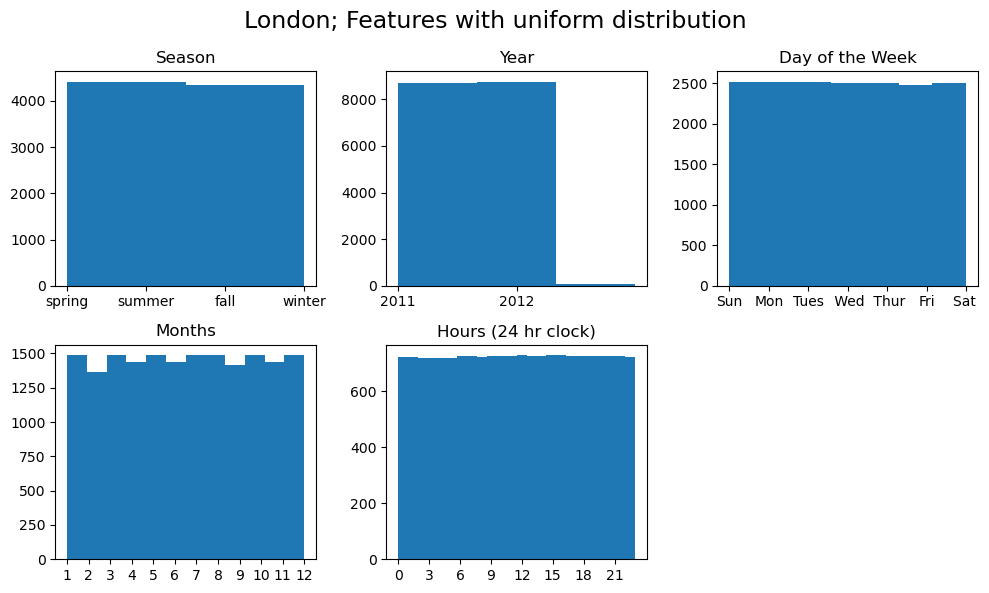

In [136]:
plt.figure(figsize=(10,6))
plt.suptitle('London; Features with uniform distribution',fontsize=17)
plt.subplot(2,3,1)
plt.tight_layout()
plt.hist(london_data['season'],bins=4)
plt.title('Season')
plt.xticks(np.arange(1,5,1),labels=(['spring','summer','fall','winter']))

plt.subplot(2,3,2)
plt.tight_layout()
plt.hist(london_data['year'],bins=3)
plt.title('Year')
plt.xticks(np.arange(0,2,1),labels=(['2011','2012']))

plt.subplot(2,3,3)
plt.tight_layout()
plt.hist(london_data['weekday'],bins=7)
plt.xticks(np.arange(0,7,1),labels=(['Sun','Mon','Tues',' Wed',' Thur','Fri','Sat ']))
plt.title('Day of the Week')

plt.subplot(2,3,4)
plt.tight_layout()
plt.hist(london_data['month'],bins=12)
plt.xticks(np.arange(1,13,1))
plt.title('Months')

plt.subplot(2,3,5)
plt.tight_layout()
plt.hist(london['hour'],bins=24)
plt.xticks(np.arange(0,24,3))
plt.title('Hours (24 hr clock)')

plt.savefig('charts/lond_uniform.png',bbox_inches='tight')